In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cProfile
from mpl_toolkits import mplot3d
import scipy.spatial

In [2]:
#Start my model
dx = 100 #map resolution (m)
dy = 20 #map resolution (m)
dxdy=dx*dy
dt = 1.0
y0 = 1 #the starting year
t_total = 50
yrs = np.arange(1, t_total, 2)
interval = t_total/50. #timesteps that are graphed


x_m = 200*100
x_s = 7000.0 #for cliff
y_m = 3000.0
b_0 = 500.0 #cliff base height

dist = np.arange(1, 200*100, 100)
x = dist
y = np.arange(1, y_m+dy, dy, dtype='int64')

Nx = len(x)
Ny = len(y)
Mny = int(Ny/2)

ELA = 2800. #ELA (m)
mdot_grad = 3. #mbgradient (mm/yr/m, default=3.)
mdot_con = 10. #mb (mm/yr)

mdot_0 = 2.0 #initial accumulation

# coefficients
A = 2.4e-24#1.0e-16 #Glen's flow law parameter A
n = 3.0
g = 9.80665 #gravity m/s^2
rho = 900.0
Gamma = 2.0*A*(rho*g)**n/(n+2) #used to shorten equations later
c_stab = 0.124#0.165

SEC_IN_YEAR = 31536000

min_ice_thick_for_length = 0.0

cfl = 0.124 #forward time stepping stability criteria
max_dt = 967224.0 #max timestep in seconds

B = np.zeros((Nx, Ny)) #Bed topo, 2D array, the topography
init_ice_think = np.zeros((Nx, Ny)) #2d array the initial ice thickness

Set the shallow ice solving methods you want to use to 1 and all other others to 0

Set the limiter you want to use to 1 and the other to 0

Set the bed shape you want to 1 and the others to 0

In [3]:
# numberical Methods
use_E = 0 #Euler
use_TVD = 1 #TVD runge Kutta Method
use_nTVD = 0 #Non TVD Runge Kutta Method

#needs to be added
use_minmod = 0 #minmod function
use_superbee = 1 #superbee function

#shallow ice solving method
use_MUSCL = 1
use_M2 = 0
use_M3 = 0
use_upstream = 0

#add a cliff in
use_cliff = 1

#Pick Bed Shape
use_rectangle = 1
use_trapazoid = 0
use_parabolic = 0

#Pick Mass Balance equation
use_steadyState = 1
use_Scalar = 0
use_linear = 0

#for use_trapazoid
gam = 2
if gam == 2:
    theta = 45

#Plots
#Time Evolution length
plt_TEL = 1
#Time Evolution Volume
plt_TEV = 1
#Surface elevation
plt_SE = 1
#Surface Width
plt_SW = 1


In [4]:
#my model Definitions
# standard minmod functioin
def minmod(a,b):
    sign = (np.sign(a)+np.sign(b))
    minmod = sign/2*(np.minimum(np.abs(a), np.abs(b)))
    return minmod

def superbee(r):
    #r = (H-Hm)/(Hp-H) #gives divide by 0 errors, makes sense when the height of the glacier is 0
    superbee =np.maximum(0,np.minimum(2.*r,1), np.minimum(r,2.)) 
    return superbee

# flux
def flux(sjpl, sjml, sjplp, sjmlp, sjlp, sjl):
    flux = (((((sjpl-sjml)+sjplp-sjmlp)**2.) / (4*dy)**2.)+(sjlp-sjl)**2./dx**2 )**((n-1.)/2.)
    return flux

# Shallow Ice approximation
def L(Dup, Sup, S, Ddn, Sdn, d):
    L=((Dup * (Sup - S))/d - (Ddn * (S - Sdn))/d)/d #equation 36 Jarosh 2013
    return L


# index
def H_index(h1, h2):
    H_index = 0.5*(h1+h2)
    return H_index

# H up index
def H_plus(H, Hp, H2p):
    if use_minmod == 1:
        H_plus = Hp - 0.5*minmod((Hp-H),(H2p-Hp))*(H2p-Hp)
    if use_superbee == 1:
        H_plus = Hp - 0.5*superbee(Hp ,H, H2p)*(H2p-Hp)
    return H_plus

# H down index
def H_min(H, Hm, Hp):
    if use_minmod == 1:
        H_min = H + 0.5*minmod((H-Hm),(Hp-H))*(Hp-H)
    if use_superbee == 1:
        H_min = H + 0.5*superbee(H,Hm,Hp)*(Hp-H)
        #if Hp - H ==0:
        #    H_min = H
        #else:
        #    H_min = H + 0.5*superbee(H,Hm,Hp)*(Hp-H)
    return H_min  
    
# Methods    
# Euler
def E(u, Lu, deltat):
    E = u-deltat*Lu
    return E

# TVD second order Runge-Kutta method
def TVDu1(u, Lu, deltat):
    TVDu1 = u+deltat*Lu
    return TVDu1

def TVD(u, Lu, L1, deltat):
    TVD = u+(0.5)*deltat*Lu+1/2*deltat*L1
    return TVD

# non TVD Runge-Kutta method method
def nTVDu1(u, Lu, deltat):
    nTVDu1 = u-20*deltat*Lu
    return nTVDu1

def nTVD(u, Lu, L1, deltat):
    nTVD = u+(41.0/40.0)*deltat*Lu-1.0/40.0*deltat*L1
    return nTVD

def accumulationss(x,mdot_0,n,x_m): 
    mdot = ((n*mdot_0)/(x_m**(2.*n-1.)))*x**(n-1.)*(abs(x_m-x)**(n-1.))*(x_m-2.*x) # Eq. 54 Jarosch 2013 
    mdot[x>x_m] = 0.
    return mdot

def accumulationl(heights):
    mdot = (heights-ELA)*(mdot_grad/1000)
    return mdot/rho

def widths(H):
    #compute the widths out of H and the bed shape
    if use_rectangle ==1:
        width = y_m
    if use_parabolic == 1:
        width = np.sqrt(4*H/Ps)
    if use_trapazoid == 1:
        width = 3
    return width
def volume_km3(H):
    volume_m3 = np.sum(H*dxdy)
    return volume_km3*1e-9

[[2500.  500.  500. ...  500.  500. 2500.]
 [2500.  500.  500. ...  500.  500. 2500.]
 [2500.  500.  500. ...  500.  500. 2500.]
 ...
 [2000.    0.    0. ...    0.    0. 2000.]
 [2000.    0.    0. ...    0.    0. 2000.]
 [2000.    0.    0. ...    0.    0. 2000.]]


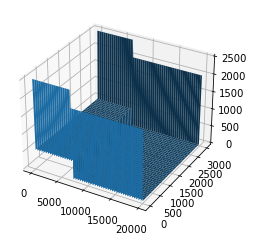

In [5]:
x0 = np.linspace(3000.,1000.,200) #base heights/ elevation bands
            
if use_rectangle == 1:
    for yd in range(Ny):
        for xd in range(Nx):
            if y[yd]< dy:
                B[xd][yd] = 2000
            if y[yd]> y_m:
                B[xd][yd] = 2000
           # B[xd][yd] = B[xd][yd]+x0[xd]
    Mny = int(Ny/2)
            
if use_trapazoid == 1:
    w0 = y_m-2*b_0
    for yd in range(Ny):
        for xd in range(Nx):
            if y[yd] <= (y_m-w0)/gam:
                base = (y_m-w0)/gam-y[yd]
                B[xd][yd] = base*np.tan(theta) 
            if y[yd] >= (y_m-w0)/gam+w0:
                base = y[yd]-(y_m-w0)/gam-w0
                B[xd][yd] = base*np.tan(theta)
            B[xd][yd] = B[xd][yd]+x0[xd]
    Mny = int(Ny/2)
    
if use_parabolic == 1:
    Ps=0.003
    for yd in range(Ny):
        think = []
        for xd in range(Nx):
            B[xd][yd]=Ps*(yd-Ny/2)**2+x0[xd]

    Mny = np.argmin(B[0][:])   
    
    
#add a cliff
if use_cliff == 1:
    for yd in range(Ny):
        for xd in range(Nx):
            if x[xd] < x_s:
                B[xd][yd] = B[xd][yd] + b_0
                
Bx,By= np.meshgrid(x,y, indexing = 'ij') #2D array of bed size/shape
ax = plt.axes(projection='3d')
ax.plot_surface(Bx, By, B, linewidths=1.0)
print(B)


In [6]:
# accumulation
m_dot = np.zeros((Nx,Ny))
if use_steadyState==1:
    mdot = accumulationss(x, mdot_0, n, x_m)
    for xd in range(Nx):
        for yd in range(Ny):
            m_dot[xd][yd] = mdot[xd]*100  
print(m_dot)    
if use_linear==1:
    for xd in range(Nx):
        for yd in range(Ny):
            mdot = accumulationl(x0[xd])
            m_dot[xd][yd] = mdot
            
if use_Scalar==1:
    m_dot = m_dot+mdot_con/1000 #units m/yr\n


[[ 1.49970002e-06  1.49970002e-06  1.49970002e-06 ...  1.49970002e-06
   1.49970002e-06  1.49970002e-06]
 [ 1.49943569e-02  1.49943569e-02  1.49943569e-02 ...  1.49943569e-02
   1.49943569e-02  1.49943569e-02]
 [ 5.81958012e-02  5.81958012e-02  5.81958012e-02 ...  5.81958012e-02
   5.81958012e-02  5.81958012e-02]
 ...
 [-1.26231194e-01 -1.26231194e-01 -1.26231194e-01 ... -1.26231194e-01
  -1.26231194e-01 -1.26231194e-01]
 [-5.70666078e-02 -5.70666078e-02 -5.70666078e-02 ... -5.70666078e-02
  -5.70666078e-02 -5.70666078e-02]
 [-1.44122079e-02 -1.44122079e-02 -1.44122079e-02 ... -1.44122079e-02
  -1.44122079e-02 -1.44122079e-02]]


In [7]:
# finite difference index y direction
k = np.arange(0, Nx)
kp = np.hstack([np.arange(1,Nx),Nx-1])
kpp = np.hstack([np.arange(2, Nx), Nx-1, Nx-1])
km = np.hstack([0, np.arange(0, Nx-1)])
kmm = np.hstack([0, 0, np.arange(0, Nx-2)])

# finite difference index x direction
l = np.arange(0, Ny)
lp = np.hstack([np.arange(1,Ny),Ny-1])
lpp = np.hstack([np.arange(2, Ny), Ny-1, Ny-1])
lm = np.hstack([0, np.arange(0, Ny-1)])
lmm = np.hstack([0, 0, np.arange(0, Ny-2)])

In [8]:
#M2 method
def M2():
    S=B#np.zeros(Nx)
    for i in range(0, timesteps-1):
        stab_t = 0.
        while stab_t<dt:
            H = S-B
            
            # calculate the l index
            H_up = H_index(H[jp],H[j])
            H_down = H_index( H[j],H[jm] )
        
            # calculate f (flux)
            f_plus = flux(S[jp],S[j])
            f_min = flux(S[j],S[jm])
            
            # Calculate Diffusivity
            D_up = Gamma * H_up**(n+2) * f_plus
            D_dn = Gamma * H_down**(n+2) * f_min 

            # calculate deltat and stab_t
            dt_stab = c_stab * dx**2. / max(np.max(np.abs(D_up)),np.max(np.abs(D_dn)))
            deltat = min(dt_stab,dt-stab_t)
            stab_t = stab_t + deltat
        

            # the time step
            div_q = L(D_up,S[jp], S[j], D_dn, S[jm]) #equation 36 Jarosh 2013
            S = S[j] + (m_dot+div_q)*deltat #equation 35 Jarosh 2013
            S = np.maximum(S,B)
             
        if np.mod(i,interval)==0.0:
            #print('timestep: ', i)
            plt.plot(x/1000,S, '-r')

In [9]:
#upstream method
def upstream():
    #Initial conditions
    S = B
    #for yd in range(Ny):
    #    for xd in range(Ny):
    #        if xd < 1000:# and S[xd][yd]==x0[xd]:
    #            S[xd][yd] = S[xd][yd]+100
    #H = S-B #H = ice thinkness, S = Surface height, B = bed topography
    for i in yrs:
        stab_t = 0.
        while stab_t<dt:
            H = S-B #H = ice thinkness, S = Surface height, B = bed topography  
            
            #optimize
            Sklp = S[k][:,lp]
            Sklm = S[k][:,lm]
            Skplp = S[kp][:,lp]
            Skplm = S[kp][:,lm]
            Skpl = S[kp][:,l]
            Skl = S[k][:,l]
            Skmlp = S[km][:,lp]
            Skmlm = S[km][:,lm]
            Skml = S[km][:,l]
            
            #calculate l indecies
            Hl = H[k][:,l]
            Hlp = H[k][:,lp]
            Hlm = H[k][:,lm]
            
            H_l_up = H_index( Hlp , Hl )
            H_l_down = H_index( Hl , Hlm )
            
            # l upstream    
            H_l_upstream_up = np.zeros((Nx,Ny))
            H_l_upstream_up[S[k][:,lp]>S[k][:,l]] = Hlp[S[k][:,lp]>S[k][:,l]]
            H_l_upstream_up[S[k][:,l]>= S[k][:,lp]] = Hl[S[k][:,l]>= S[k][:,lp]]
                    
            H_l_upstream_down = np.zeros((Nx,Ny))
            H_l_upstream_down[S[k][:,l] > S[k][:,lm]] = Hl[S[k][:,l] > S[k][:,lm]]
            H_l_upstream_down[S[k][:,lm]>=S[k][:,l]] = Hlm[S[k][:,lm]>=S[k][:,l]]          
            
            #calculate l flux
            f_l_plus = flux(Skpl, Skml, Skplp, Skmlp, Sklp, Skl)
            f_l_min = flux(Skpl, Skml, Skplm, Skmlm, Skl, Sklm)
            
            # calculate l Diffusivity
            D_l_up = Gamma * H_l_up**(n+1) * H_l_upstream_up * f_l_plus
            D_l_dn = Gamma * H_l_down**(n+1) * H_l_upstream_down * f_l_min
        
            #calculate j indecies 
            Hk = H[k][:,l]
            Hkp = H[kp][:,l]
            Hkm = H[km][:,l]
            
            H_k_up = H_index( Hkp , Hk )
            H_k_down = H_index( Hk , Hkm )
            
            # j upstream    
            H_k_upstream_up = np.zeros((Nx,Ny))
            H_k_upstream_up[Skpl>Skl] = Hkp[Skpl>Skl]
            H_k_upstream_up[Skl>= Skpl] = Hk[Skl>= Skpl]
                    
            H_k_upstream_down = np.zeros((Nx,Ny))
            H_k_upstream_down[Skl > Skml] = Hk[Skl > Skml]
            H_k_upstream_down[Skml>=Skl] = Hkm[Skml>=Skl]
            
            #calculate j flux
            f_k_plus = flux(Sklp, Sklm, Skplp, Skplm, Skpl, Skl)
            f_k_min = flux(Sklp, Sklm, Skmlp, Skmlm, Skl, Skml)
                
            # calculate j Diffusivity
            D_k_up = Gamma * H_k_up**(n+1) * H_k_upstream_up * f_k_plus
            D_k_dn = Gamma * H_k_down**(n+1) * H_k_upstream_down * f_k_min
        
            # calculate delta t and stab_t
            dt_stab = c_stab * min(dx**2., dy**2.) / max(np.max(np.abs(D_k_up)), np.max(np.abs(D_k_dn)), np.max(np.abs(D_l_dn)), np.max(np.abs(D_l_dn)))
            deltat = min(dt_stab,dt-stab_t)
            #print(dt-stab_t)
            
            if deltat > max_dt:
                deltat = max_dt
            
            #print(deltat)
            
            stab_t = stab_t + deltat
    
            # the timestep
            div_k = L(D_k_up ,Skpl ,Skl, D_k_dn, Skml, dx) #equation 36 Jarosh 2013
            div_l = L(D_l_up ,Sklp ,Skl, D_l_dn, Sklm, dy) #equation 36 Jarosh 2013
            div_q = div_k+div_l
            
            
            S= Skl + (m_dot+div_q)*deltat #equation 35 Jarosh 2013
            
            
            S = np.maximum(S,B)
            H = S-B
            #print(H)
        
        if np.mod(i,interval)==0.0:
            print('year: ', i)
            plt.plot(y,S[1][:], '-g') 
        
        if i == t_total-1:
            for j in range(Nx):
                SurfaceElevationup.append(S[j][Mny])
                #print(SurfaceElevation)
                widthup.append(widths(H[k,Mny]))
            
        Dif = np.nonzero(S[:,Mny]-B[:,Mny])

        vol = np.sum(H*dxdy)*1e-9
        #print(vol)
        #print(B[:,Mny])
        
        lengthup.append(x[Dif[0][-1]])
        volumeup.append(vol)

In [10]:
#MUSCL Scheme 
def MUSCL():
    S=B #Initial conditions
    for i in yrs:
        stab_t = 0
        while stab_t<dt:
            H = S-B
            #print("t = ", i)
            #print(H)
                
            # at the k+1/2 index
            r_k_min_up = (H[k][:,l]-H[km][:,l])/(H[kp][:,l]-H[k][:,l])
            H_k_min_up = H[k][:,l] + 0.5 * superbee(r_k_min_up)*(H[kp][:,l] - H[k][:,l])
            
            r_k_plus_up = (H[kp][:,l]-H[k][:,l])/(H[kpp][:,l]-H[kp][:,l])
            H_k_plus_up = H[kp][:,l] - 0.5 * superbee(r_k_plus_up)*(H[kpp][:,l] - H[kp][:,l])
            
                
            # at the k-1/2 index
            r_k_min_down = (H[km][:,l]-H[kmm][:,l])/(H[k][:,l]-H[km][:,l])
            H_k_min_down = H[km][:,l] + 0.5 * superbee(r_k_min_down)*(H[k][:,l] - H[km][:,l])
            
            r_k_plus_down = (H[k][:,l]-H[km][:,l])/(H[kp][:,l]-H[k][:,l])
            H_k_plus_down = H[k][:,l] - 0.5 * superbee(r_k_plus_down)*(H[kp][:,l] - H[k][:,l])
            
            # at the l+1/2 index
            r_l_min_up = (H[k][:,l]-H[k][:,lm])/(H[k][:,lp]-H[k][:,l])
            H_l_min_up = H[k][:,l] + 0.5 * superbee(r_l_min_up)*(H[k][:,lp] - H[k][:,l])
            
            r_l_plus_up = (H[k][:,lp]-H[k][:,l])/(H[k][:,lpp]-H[k][:,lp])
            H_l_plus_up = H[k][:,lp] - 0.5 * superbee(r_l_plus_up)*(H[k][:,lpp] - H[k][:,lp])
            
                
            # at the l-1/2 index
            r_l_min_down = (H[k][:,lm]-H[k][:,lmm])/(H[k][:,l]-H[k][:,lm])
            H_l_min_down = H[k][:,lm] + 0.5 * superbee(r_l_min_down)*(H[k][:,l] - H[k][:,lm])
            
            r_l_plus_down = (H[k][:,l]-H[k][:,lm])/(H[k][:,lp]-H[k][:,l])
            H_l_plus_down = H[k][:,l] - 0.5 * superbee(r_l_plus_down)*(H[k][:,lp] - H[k][:,l])
            
            Sklp = S[k][:,lp]
            Sklm = S[k][:,lm]
            Skplp = S[kp][:,lp]
            Skplm = S[kp][:,lm]
            Skpl = S[kp][:,l]
            Skl = S[k][:,l]
            Skmlp = S[km][:,lp]
            Skmlm = S[km][:,lm]
            Skml = S[km][:,l]
                
            f_k_plus = flux(Sklp, Sklm, Skplp, Skplm, Skpl, Skl)
            #print('f_k_plus = ', f_k_plus)
            f_k_min = flux(Sklp, Sklm, Skmlp, Skmlm, Skl, Skml)
            #print('f_k_min = ', f_k_min)
            
            #calculate l flux
            f_l_plus = flux(Skpl, Skml, Skplp, Skmlp, Sklp, Skl)
            #print('f_l_plus = ', f_l_plus)
            f_l_min = flux(Skpl, Skml, Skplm, Skmlm, Skl, Sklm)
            #print('f_l_min = ', f_l_min)
                
            # calculate k Diffusivity
            D_k_up_m = Gamma * H_k_min_up**(n+2.) * f_k_plus #Equation 30 jarosch 2013
            D_k_up_p = Gamma * H_k_plus_up**(n+2.) * f_k_plus #Equation 30 Jarosch 2013
            D_k_up_min = np.minimum(D_k_up_m, D_k_up_p) #equation 31 Jarosch 2013
            D_k_up_max = np.maximum(D_k_up_m, D_k_up_p) #equation 32 Jarosch 2013
                
            D_k_dn_m = Gamma * H_k_min_down**(n+2) * f_k_min #Equation 30 Jarosch 2013
            D_k_dn_p = Gamma * H_k_plus_down**(n+2) * f_k_min #Equation 30 Jarosh 2013
            D_k_dn_min = np.minimum(D_k_dn_m, D_k_dn_p) #equation 31 Jarosch 2013
            D_k_dn_max = np.maximum(D_k_dn_m, D_k_dn_p) #equatioon 32 Jarosch 2013
                
            #equation 33 jarosh 2013
            D_k_up = np.zeros((Nx, Ny))
            
            D_k_up[np.logical_and(Skpl<=Skl,H_k_min_up<=H_k_plus_up)] = D_k_up_min[np.logical_and(Skpl<=Skl,H_k_min_up<=H_k_plus_up)]
            D_k_up[np.logical_and(Skpl<=Skl,H_k_min_up>H_k_plus_up)] = D_k_up_max[np.logical_and(Skpl<=Skl,H_k_min_up>H_k_plus_up)]
            D_k_up[np.logical_and(Skpl>Skl,H_k_min_up<=H_k_plus_up)] = D_k_up_max[np.logical_and(Skpl>Skl,H_k_min_up<=H_k_plus_up)]
            D_k_up[np.logical_and(Skpl>Skl,H_k_min_up>H_k_plus_up)] = D_k_up_min[np.logical_and(Skpl>Skl,H_k_min_up>H_k_plus_up)]
        
            D_k_dn = np.zeros((Nx,Ny))
            
            D_k_dn[np.logical_and(Skl<=Skml,H_k_min_down<=H_k_plus_down)] = D_k_dn_min[np.logical_and(Skl<=Skml,H_k_min_down<=H_k_plus_down)]
            D_k_dn[np.logical_and(Skl<=Skml,H_k_min_down>H_k_plus_down)] = D_k_dn_max[np.logical_and(Skl<=Skml,H_k_min_down>H_k_plus_down)]
            D_k_dn[np.logical_and(Skl>Skml,H_k_min_down<=H_k_plus_down)] = D_k_dn_max[np.logical_and(Skl>Skml,H_k_min_down<=H_k_plus_down)]
            D_k_dn[np.logical_and(Skl>Skml,H_k_min_down>H_k_plus_down)] = D_k_dn_min[np.logical_and(Skl>Skml,H_k_min_down>H_k_plus_down)]
            
            # calculate l Diffusivity
            D_l_up_m = Gamma * H_l_min_up**(n+2.) * f_l_plus #Equation 30 Jarosch 2013
            D_l_up_p = Gamma * H_l_plus_up**(n+2.) * f_l_plus #Equation 30 Jarosch 2013
            D_l_up_min = np.minimum(D_l_up_m, D_l_up_p) #equation 31 Jarosch 2013
            D_l_up_max = np.maximum(D_l_up_m, D_l_up_p) #equation 32 Jarosch 2013
                
            D_l_dn_m = Gamma * H_l_min_down**(n+2) * f_l_min #Equation 30 Jarosch 2013
            D_l_dn_p = Gamma * H_l_plus_down**(n+2) * f_l_min #Equation 30 Jarosh 2013
            D_l_dn_min = np.minimum(D_l_dn_m, D_l_dn_p) #equation 31 Jarosch 2013
            D_l_dn_max = np.maximum(D_l_dn_m, D_l_dn_p) #equatioon 32 Jarosch 2013
                
            #equation 33 jarosh 2013
            D_l_up = np.zeros((Nx, Ny))
            
            D_l_up[np.logical_and(Sklp<=Skl,H_l_min_up<=H_l_plus_up)] = D_l_up_min[np.logical_and(Sklp<=Skl,H_l_min_up<=H_l_plus_up)]
            D_l_up[np.logical_and(Sklp<=Skl,H_l_min_up>H_l_plus_up)] = D_l_up_max[np.logical_and(Sklp<=Skl,H_l_min_up>H_l_plus_up)]
            D_l_up[np.logical_and(Sklp>Skl,H_l_min_up<=H_l_plus_up)] = D_l_up_max[np.logical_and(Sklp>Skl,H_l_min_up<=H_l_plus_up)]
            D_l_up[np.logical_and(Sklp>Skl,H_l_min_up>H_l_plus_up)] = D_l_up_min[np.logical_and(Sklp>Skl,H_l_min_up>H_l_plus_up)]
        
            D_l_dn = np.zeros((Nx,Ny))
            
            D_l_dn[np.logical_and(Skl<=Sklm,H_l_min_down<=H_l_plus_down)] = D_l_dn_min[np.logical_and(Skl<=Sklm,H_l_min_down<=H_l_plus_down)]
            D_l_dn[np.logical_and(Skl<=Sklm,H_l_min_down>H_l_plus_down)] = D_l_dn_max[np.logical_and(Skl<=Sklm,H_l_min_down>H_l_plus_down)]
            D_l_dn[np.logical_and(Skl>Sklm,H_l_min_down<=H_l_plus_down)] = D_l_dn_max[np.logical_and(Skl>Sklm,H_l_min_down<=H_l_plus_down)]
            D_l_dn[np.logical_and(Skl>Sklm,H_l_min_down>H_l_plus_down)] = D_l_dn_min[np.logical_and(Skl>Sklm,H_l_min_down>H_l_plus_down)]
                
            # calculate delta t and stab_t
            dt_stab = c_stab * dx**2. / max(np.max(abs(D_k_up)),np.max(abs(D_k_dn)), np.max(abs(D_l_up)),np.max(abs(D_l_dn)))
            deltat = min(dt_stab,dt-stab_t)
            stab_t = stab_t + deltat
            
            
            # the time step
            div_k = L(D_k_up,Skpl, Skl, D_k_dn, Skml, dx) #equation 36 Jarosh 2013
            div_l = L(D_l_up,Sklp, Skl, D_l_dn, Sklm, dy) #equation 36 Jarosh 2013
            div_q = div_k+div_l
            S = Skl + (m_dot+div_q)*deltat #equation 35 Jarosh 2013
            S = np.maximum(S,B)
            #print('S = ')
            #print(S[:,0])
  
        if np.mod(i,interval)==0.0:
            plt.plot(x/1000,S, '-b')
            print('year: ' ,i)
        
        if i == t_total-1:
            for j in range(Nx):
                SurfaceElevationM.append(S[j][Mny])
                #print(SurfaceElevation)
                widthM.append(widths(H[k,Mny]))
            
        Dif = np.nonzero(S[:,Mny]-B[:,Mny])

        vol = np.sum(H*dxdy)*1e-9
        #print(vol)
        #print(B[:,Mny])
        
        lengthM.append(x[Dif[0][-1]])
        volumeM.append(vol)

In [11]:
# Run
if use_upstream == 1:
    lengthup = []
    volumeup = []
    SurfaceElevationup = []
    widthup = []
    upstream()
    #p3, = plt.plot(0,0, '-g')
    #cProfile.run("upstream()")
if use_MUSCL == 1:
    lengthM = []
    volumeM = []
    SurfaceElevationM = []
    widthM = []
    MUSCL()
#p5, = plt.plot(y,B[1,:], '-k', linewidth = 4)
#plt.xlabel('x m')
#plt.ylabel('Height (m)')
#plt.ylim(np.min(B[1,:])-50, 6000)
#plt.title("Upstream 2D")
#plt.savefig('Glacier Model 2D')

<ipython-input-10-dcf2bdb86493>:12: RuntimeWarning: invalid value encountered in true_divide
  r_k_min_up = (H[k][:,l]-H[km][:,l])/(H[kp][:,l]-H[k][:,l])
<ipython-input-10-dcf2bdb86493>:15: RuntimeWarning: invalid value encountered in true_divide
  r_k_plus_up = (H[kp][:,l]-H[k][:,l])/(H[kpp][:,l]-H[kp][:,l])
<ipython-input-10-dcf2bdb86493>:20: RuntimeWarning: invalid value encountered in true_divide
  r_k_min_down = (H[km][:,l]-H[kmm][:,l])/(H[k][:,l]-H[km][:,l])
<ipython-input-10-dcf2bdb86493>:23: RuntimeWarning: invalid value encountered in true_divide
  r_k_plus_down = (H[k][:,l]-H[km][:,l])/(H[kp][:,l]-H[k][:,l])
<ipython-input-10-dcf2bdb86493>:27: RuntimeWarning: invalid value encountered in true_divide
  r_l_min_up = (H[k][:,l]-H[k][:,lm])/(H[k][:,lp]-H[k][:,l])
<ipython-input-10-dcf2bdb86493>:30: RuntimeWarning: invalid value encountered in true_divide
  r_l_plus_up = (H[k][:,lp]-H[k][:,l])/(H[k][:,lpp]-H[k][:,lp])
<ipython-input-10-dcf2bdb86493>:35: RuntimeWarning: invalid val

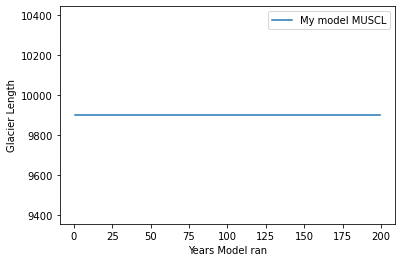

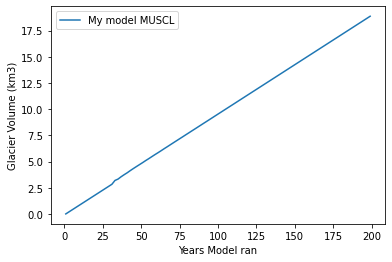

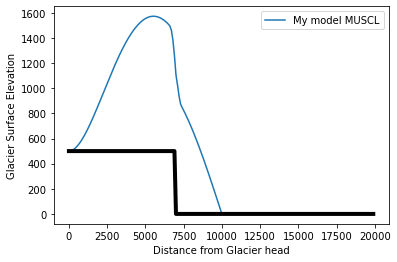

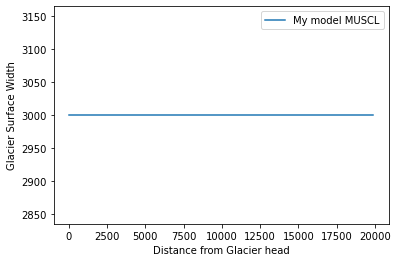

In [12]:
#plots
if plt_TEL == 1:
    if use_MUSCL == 1:
        plt.plot(yrs, lengthM, label = 'My model MUSCL')
    if use_upstream == 1:
        plt.plot(yrs, lengthup, label = 'My model Upstream')
    plt.xlabel('Years Model ran')
    plt.ylabel('Glacier Length')
    plt.legend()
    plt.show()
if plt_TEV ==1:
    if use_MUSCL == 1:
        plt.plot(yrs, volumeM, label = 'My model MUSCL')
    if use_upstream == 1:
        plt.plot(yrs, volumeup, label = 'My model Upsteam')
    plt.xlabel('Years Model ran')
    plt.ylabel('Glacier Volume (km3)')
    plt.legend()
    plt.show()
if plt_SE ==1:
    if use_MUSCL == 1:
        plt.plot(dist,SurfaceElevationM, label = 'My model MUSCL')
    if use_upstream == 1:
        plt.plot(dist,SurfaceElevationup, label = 'My model Upsteam')
    plt.plot(dist,B[:,Mny], '-k', linewidth = 4)
    plt.xlabel('Distance from Glacier head')
    plt.ylabel('Glacier Surface Elevation')
    plt.legend()
    plt.show()
if plt_SW == 1:
    if use_MUSCL == 1:
        plt.plot(dist,widthM, label = "My model MUSCL")
    if use_upstream == 1:
        plt.plot(dist,widthup, label = "My model Upstream")
    plt.xlabel('Distance from Glacier head')
    plt.ylabel('Glacier Surface Width')
    plt.legend()
    plt.show()

In [13]:
#S=np.zeros(Nx) #Initial conditions
#S[x<x_s]=b_0
#for n in range(0, timesteps-1):
#    U = []
#    # set deltat
#    if use_E==1:
#        deltat = dx/2
#    if use_TVD==1 or use_nTVD==1:
#        deltat = (dx/2)/np.amax(np.abs(u))
#    
#    # Calculate u1
#    if use_TVD==1 or use_nTVD==1:
#        for j in range(2, Nx-2):
#            # caluculate the j-1/2 index
#            u_min_up = u_min(u[j-1][n], u[j][n], u[j+1][n])
#            u_plus_up = u_plus(u[j][n],u[j+1][n], u[j+2][n])
#        
#            # calculate the j+1/2 index
#            u_min_down = u_min(u[j-2][n], u[j-1][n], u[j][n])
#            u_plus_down = u_plus(u[j-1][n], u[j][n], u[j+1][n])
#        
#            # calculate f (numerical flux)
#            f_plus = h(u_min_up, u_plus_up)
#            f_min = h(u_min_down, u_plus_down)
#        
#            # Calculate L
#            Lu = L(f_plus, f_min)
#        
#            if use_TVD ==1:
#                u1[j][n] = TVDu1(u[j][n], Lu, deltat)
#            if use_nTVD ==1:
#                u1[j][n] = nTVDu1(u[j][n], Lu, deltat)
#            #print(u1[j][n])
#            
#    for j in range(2, Nx-2):
#        if use_TVD==1 or use_nTVD==1:
#            # To calculate L1 you need to calculate f off the u1 values
#            # calculate the j-1/2
#            u1_min_up = u_min(u1[j-1][n], u1[j][n], u1[j+1][n])
#            u1_plus_up = u_plus(u1[j][n],u1[j+1][n], u1[j+2][n])
#        
#            # calculate the j+1/2 index
#            u1_min_down = u_min(u[j-2][n], u1[j-1][n], u1[j][n])
#            u1_plus_down = u_plus(u[j-1][n], u1[j][n], u1[j+1][n])
#            
#            # calculate f1
#            f1_plus = h(u1_min_up, u1_plus_up)
#            f1_min = h(u1_min_down, u1_plus_down)
#            
#            # calculate L1
#            L1 = L(f1_plus, f1_min)
#         
#        # calculate u
#        # calculate the j-1/2 index
#        u_min_up = u_min(u[j-1][n], u[j][n], u[j+1][n])
#        u_plus_up = u_plus(u[j][n],u[j+1][n], u[j+2][n])
#        
#        # calculate the j+1/2 index
#        u_min_down = u_min(u[j-2][n], u[j-1][n], u[j][n])
#        u_plus_down = u_plus(u[j-1][n], u[j][n], u[j+1][n])
#        
#        # calculate f (numerical flux)
#        f_plus = h(u_min_up, u_plus_up)
#        f_min = h(u_min_down, u_plus_down)
#        
#        # Calculate L
#        if use_E==1:
#            Lu = Lbar(f_plus, f_min)
#        if use_TVD==1 or use_nTVD==1:
#            Lu = L(f_plus, f_min)
#        
#        if use_E==1:
#            unplus = E(u[j][n],Lu, deltat) #equation 1.10 (Gottlieb 1998)
#        if use_TVD==1:
#            unplus = TVD(u[j][n], Lu, L1, deltat) #equation 2.4 (Gottlieb 1998)
#        if use_nTVD ==1:
#            unplus = nTVD(u[j][n], Lu, L1, deltat) #equation 2.5 (Gottlieb 1998)
#            
#        u[j][n+1] = unplus
#        
#        U.append(u[j][n])    
#    #print(U)
#            
#plt.plot(xx,U)
#plt.plot(x/1000,B,'-k',linewidth=2)

# 